In [8]:
import copy

from alns import ALNS
from alns.select import RouletteWheel
from alns.stop import MaxRuntime
from alns.accept import HillClimbing

import numpy as np
import pandas as pd
from classes.deliveryrouting import DeliveryRouting

In [9]:
def random_destroy(State : DeliveryRouting, rnd_state : np.random.seed = np.random.seed(42)):
    destroyed = copy.deepcopy(State)
    destroyed.current_solution = copy.deepcopy(destroyed.final_result)

    order_to_destroy = np.random.choice(destroyed.orders, 10)
    destroyed.unassigned = order_to_destroy

    mapping = []

    for order_destroyed in order_to_destroy:
        for time, routes in destroyed.final_result.items():
            for route in routes:
                for bundle in route:
                    if order_destroyed in bundle.bundle:
                        bundle.bundle.remove(order_destroyed)
                        mapping.append(dict(time = time, order = order_destroyed))

    destroyed.removed = mapping
    return destroyed

In [10]:
def greedy_assign(State: DeliveryRouting, rnd_state : np.random.seed = np.random.seed(42)):
    repaired = copy.deepcopy(State)
    destroyed_order = repaired.unassigned

    for i in repaired.removed:
        time, destroyed_order = i.values()
        source_restaurant_id = destroyed_order.restaurant_id

        min_time = 1e9

        routes = repaired.final_result[time]
        for route in routes:
            for bundle in route:
                if len(bundle.bundle) > 0:
                    restaurant_id = bundle.bundle[0].restaurant_id
                    if restaurant_id == source_restaurant_id:
                        for i in range(len(bundle.bundle)):
                            temp_bundle = copy.deepcopy(bundle)
                            temp_bundle.bundle.insert(i, destroyed_order)

                            if temp_bundle.get_route_cost(repaired.meters_per_minute, repaired.locations) < min_time:
                                min_time = temp_bundle.get_route_cost(repaired.meters_per_minute, repaired.locations)
                                best_route = route.index(bundle)
                                best_position = i
                                best_routes = routes.index(route)
                else:
                    best_routes = routes.index(route)
                    best_route = route.index(bundle)
                    best_position = 0

        to_check = repaired.final_result[time][best_routes][best_route]
        to_check.bundle.insert(best_position, destroyed_order)

    return repaired

In [11]:
import os
import numpy.random as rnd

In [27]:
output = {}
for file in os.listdir("data"):
    instance_dir = os.path.join("data", file)
    dr = DeliveryRouting(instance_dir)
    dr.driver_code()
    alns = ALNS(rnd.RandomState(42))
    alns.add_destroy_operator(random_destroy)
    alns.add_repair_operator(greedy_assign)

    init = dr
    select = RouletteWheel([8, 4, 2, 1], 0.8, 1, 1)
    accept = HillClimbing()
    stop = MaxRuntime(30)

    result = alns.iterate(init, select, accept, stop)
    output[file] = result.statistics.objectives

In [31]:
import json

output_dup = copy.deepcopy(output)

for k, v in output.items():
    output[k] = list(v)

with open("output.json", "w") as f:
    json.dump(output, f)

In [41]:
final = []
for k, v in output.items():
    final.append(dict(instance = k, cost_reduction = v[0] - np.min(v), cost = np.argmin(v)))

In [42]:
final_df = pd.DataFrame(final)

In [49]:
final_df[final_df['cost_reduction'] < 0]

,instance,cost_reduction,cost


Text(0.5, 0.98, 'Cost reduction for 30 seconds runtime')

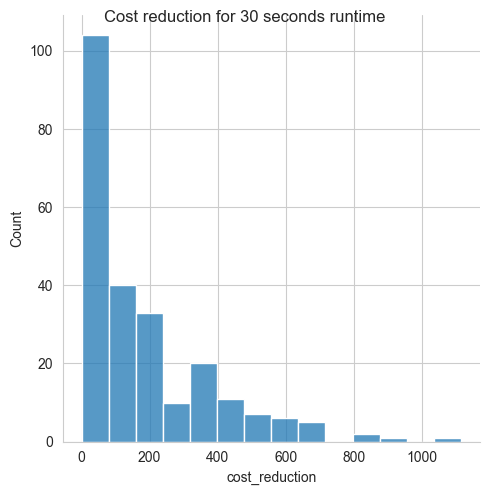

In [53]:
import seaborn as sns
plot = sns.displot(data = final_df, x = 'cost_reduction')
plot.fig.suptitle("Cost reduction for 30 seconds runtime")

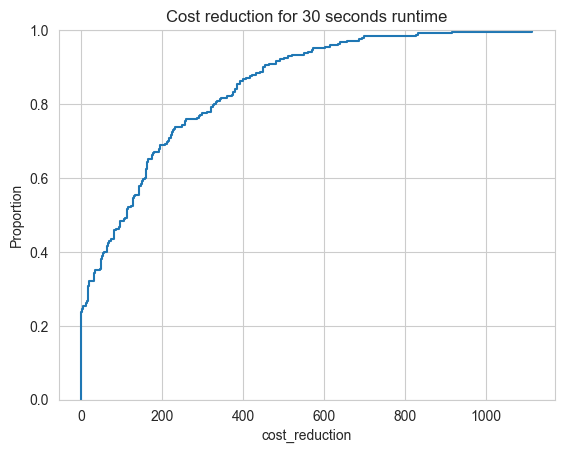

In [54]:
import seaborn as sns
plot = sns.ecdfplot(data = final_df, x = 'cost_reduction').set_title("Cost reduction for 30 seconds runtime")

In [57]:
final_df[final_df['cost_reduction']==final_df['cost_reduction'].max()]

,instance,cost_reduction,cost
165,0o50t100s1p100,1114.0,361
